<h2> Before moving to images folder, Augment ! </h2>

In [1]:
import os
!mkdir /kaggle/working/data
sharp_folder = "/kaggle/input/blur-dataset/sharp"
main = "/kaggle/working/data"
!mkdir /kaggle/working/data/RGB
!mkdir /kaggle/working/data/BGR
os.listdir(main)

['RGB', 'BGR']

In [4]:
import os
from PIL import Image
import numpy as np

sharp_dir = '/kaggle/input/blur-dataset/sharp'
bgr_dir = '/kaggle/working/data/BGR'

# Convert images to BGR and save to BGR directory
for image_name in os.listdir(sharp_dir):
    sharp_image_path = os.path.join(sharp_dir, image_name)
    sharp_image = Image.open(sharp_image_path)
    bgr_image_name = os.path.splitext(image_name)[0] + '.jpg'
    bgr_image_path = os.path.join(bgr_dir, bgr_image_name)
    bgr_image = np.array(sharp_image)[:, :, ::-1]
    bgr_image = Image.fromarray(bgr_image)
    bgr_image.save(bgr_image_path)


In [9]:
!mkdir /kaggle/working/data/RGB

In [11]:
import os
import shutil

sharp_dir = "/kaggle/input/blur-dataset/sharp"
rgb_dir = '/kaggle/working/data/RGB'

for filename in os.listdir(sharp_dir):
    if os.path.isfile(os.path.join(sharp_dir, filename)):
        shutil.copy(os.path.join(sharp_dir, filename), rgb_dir)


In [14]:
%%capture

! pip install transformers pytorch-lightning --quiet

In [13]:
import math
import shutil
from PIL import Image
from io import BytesIO
import torch
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from torchmetrics import Accuracy
from torchvision.datasets import ImageFolder
from transformers import ViTFeatureExtractor, ViTForImageClassification

## Init Dataset and Split into Training and Validation Sets


In [15]:
data_dir = '/kaggle/working/data'

In [17]:
ds = ImageFolder(data_dir)
indices = torch.randperm(len(ds)).tolist()
n_val = math.floor(len(indices) * .15)
train_ds = torch.utils.data.Subset(ds, indices[:-n_val])
val_ds = torch.utils.data.Subset(ds, indices[-n_val:])

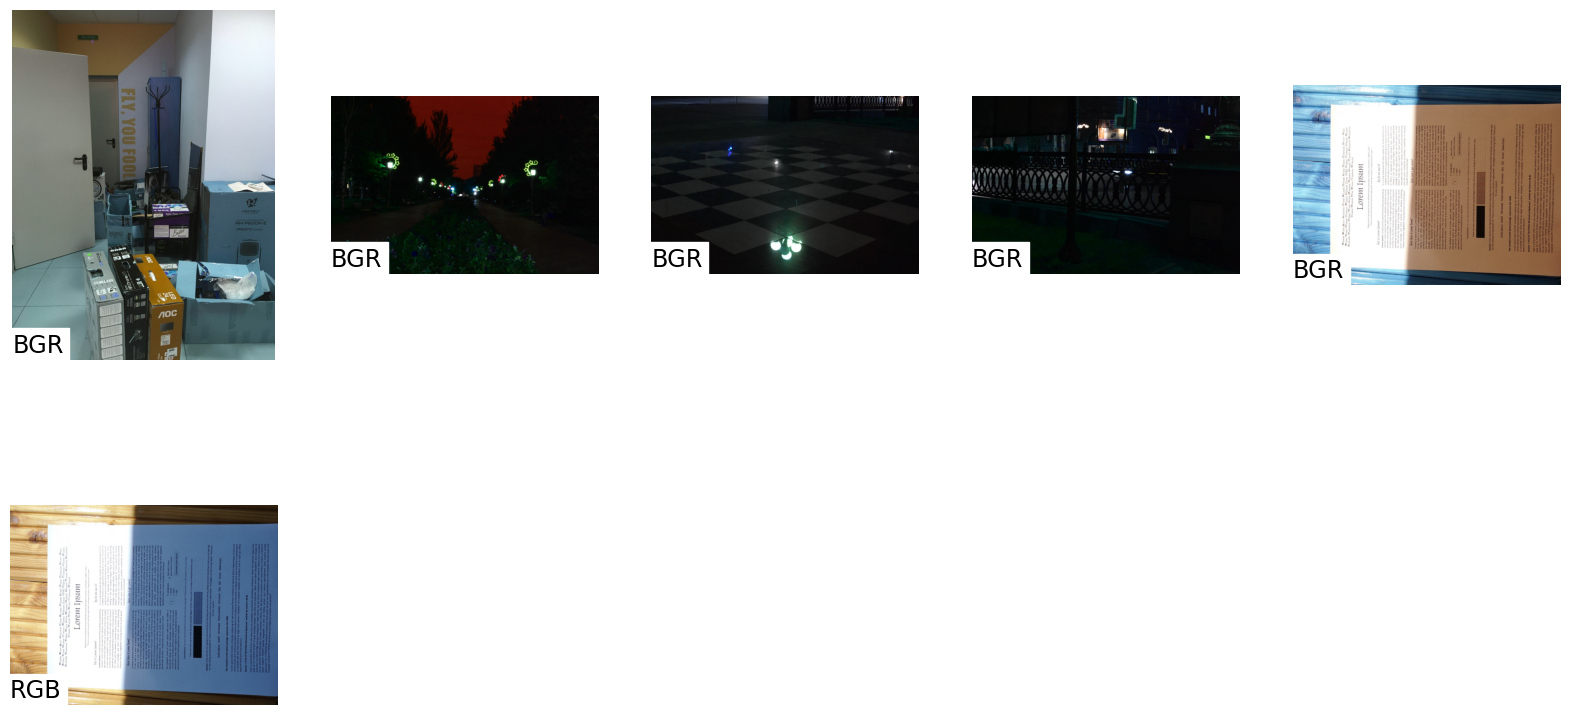

In [18]:
import matplotlib.pyplot as plt
from pathlib import Path

plt.figure(figsize=(20,10))
num_examples_per_class = 5
i = 1
for class_idx, class_name in enumerate(ds.classes):
    folder = Path(ds.root) / class_name
    for image_idx, image_path in enumerate(sorted(folder.glob('*'))):
        if image_path.suffix in ds.extensions:
            image = Image.open(image_path)
            plt.subplot(len(ds.classes), num_examples_per_class, i)
            ax = plt.gca()
            ax.set_title(
                class_name,
                size='xx-large',
                pad=5,
                loc='left',
                y=0,
                backgroundcolor='white'
            )
            ax.axis('off')
            plt.imshow(image)
            i += 1

            if image_idx + 1 == num_examples_per_class:
                break


In [19]:
!tree /kaggle/working/data

/kaggle/working/data
├── BGR
│   ├── 0_IPHONE-SE_S.jpg
│   ├── 100_NIKON-D3400-35MM_S.jpg
│   ├── 101_NIKON-D3400-35MM_S.jpg
│   ├── 102_NIKON-D3400-35MM_S.jpg
│   ├── 103_HUAWEI-P20_S.jpg
│   ├── 104_IPHONE-SE_S.jpg
│   ├── 105_IPHONE-SE_S.jpg
│   ├── 106_NIKON-D3400-35MM_S.jpg
│   ├── 107_XIAOMI-MI8-SE_S.jpg
│   ├── 108_XIAOMI-MI8-SE_S.jpg
│   ├── 109_HONOR-7X_S.jpg
│   ├── 10_ASUS-ZENFONE-LIVE-ZB501KL_S.jpg
│   ├── 110_IPHONE-7_S.jpg
│   ├── 111_IPHONE-7_S.jpg
│   ├── 112_NIKON-D3400-35MM_S.jpg
│   ├── 113_SAMSUNG-GALAXY-A5_S.jpg
│   ├── 114_ASUS-ZE500KL_S.jpg
│   ├── 115_NIKON-D3400-35MM_S.jpg
│   ├── 116_BQ-5512L_S.jpg
│   ├── 117_HONOR-7X_S.jpg
│   ├── 118_HONOR-7X_S.jpg
│   ├── 119_HONOR-7X_S.jpg
│   ├── 11_XIAOMI-MI8-SE_S.jpg
│   ├── 120_HONOR-7X_S.jpg
│   ├── 121_HONOR-7X_S.jpg
│   ├── 122_HONOR-7X_S.jpg
│   ├── 123_NIKON-D3400-35MM_S.jpg
│   ├── 124_HONOR-7X_S.jpg
│   ├── 125_NIKON-D3400-35MM_S.jpg
│   ├── 126_NIKON-D3400-18-55MM_S.jpg
│   ├── 127_IPHONE-8_S.jpg
│   ├── 128_X

## Preparing Labels for Our Model's Config

By adding `label2id` + `id2label` to our model's config, we'll get friendlier labels in the inference API.

In [20]:
label2id = {}
id2label = {}

for i, class_name in enumerate(ds.classes):
    label2id[class_name] = str(i)
    id2label[str(i)] = class_name

## Image Classification Collator

To apply our transforms to images, we'll use a custom collator class. We'll initialize it using an instance of `ViTFeatureExtractor` and pass the collator instance to `torch.utils.data.DataLoader`'s `collate_fn` kwarg.

In [21]:
class ImageClassificationCollator:
    def __init__(self, feature_extractor):
        self.feature_extractor = feature_extractor
 
    def __call__(self, batch):
        encodings = self.feature_extractor([x[0] for x in batch], return_tensors='pt')
        encodings['labels'] = torch.tensor([x[1] for x in batch], dtype=torch.long)
        return encodings 

## Init Feature Extractor, Model, Data Loaders


In [22]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=len(label2id),
    label2id=label2id,
    id2label=id2label
)
collator = ImageClassificationCollator(feature_extractor)
train_loader = DataLoader(train_ds, batch_size=8, collate_fn=collator, num_workers=2, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8, collate_fn=collator, num_workers=2)

/opt/conda/lib/python3.7/site-packages/transformers/models/vit/feature_extraction_vit.py:31: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  FutureWarning,


Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Training

⚡ We'll use [PyTorch Lightning](https://pytorchlightning.ai/) to fine-tune our model.

In [23]:
class Classifier(pl.LightningModule):

    def __init__(self, model, lr: float = 2e-5, **kwargs):
        super().__init__()
        self.save_hyperparameters('lr', *list(kwargs))
        self.model = model
        self.forward = self.model.forward
        self.val_acc = Accuracy(
            task='binary',
            num_classes=model.config.num_labels
        )

    def training_step(self, batch, batch_idx):
        outputs = self(**batch)
        self.log(f"train_loss", outputs.loss)
        return outputs.loss

    def validation_step(self, batch, batch_idx):
        outputs = self(**batch)
        self.log(f"val_loss", outputs.loss)
        acc = self.val_acc(outputs.logits.argmax(1), batch['labels'])
        self.log(f"val_acc", acc, prog_bar=True)
        return outputs.loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

In [24]:
pl.seed_everything(42)

classifier = Classifier(model, lr=2e-5)
trainer = pl.Trainer(accelerator='gpu', devices=1, precision=16, max_epochs=20)
trainer.fit(classifier, train_loader, val_loader)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [25]:
val_batch = next(iter(val_loader))
outputs = model(**val_batch)
print('Preds: ', outputs.logits.softmax(1).argmax(1))
print('Labels:', val_batch['labels'])

Preds:  tensor([1, 1, 0, 0, 0, 0, 1, 1])
Labels: tensor([1, 1, 0, 0, 0, 0, 1, 1])


In [26]:
# save the model
model_dir = "./"
model_name = "vit_model"
model.save_pretrained(model_dir + model_name)


In [ ]:
from PIL import Image

# Load the saved model
model_dir = "./"
model_name = "vit_model"
loaded_model = ViTForImageClassification.from_pretrained(model_dir + model_name)

# Load and preprocess the image
image_path = "/content/90anticlock.jpg"
image = Image.open(image_path)
inputs = feature_extractor(image, return_tensors="pt")

# Make the prediction
outputs = loaded_model(**inputs)
predicted_class = id2label[str(outputs.logits.argmax(1).item())]

print(f"Predicted class: {predicted_class}")


In [27]:
 !zip -r model.zip /kaggle/working/vit_model

  adding: kaggle/working/vit_model/ (stored 0%)
  adding: kaggle/working/vit_model/pytorch_model.bin (deflated 7%)
  adding: kaggle/working/vit_model/config.json (deflated 47%)


In [ ]:
! du -sh /kaggle/working/vit_model